# Text Analysis (Adapted from Garrent Gaut's 2016 Tutorial)

---

## Introduction

Text Analysis is used for summarizing or getting useful information out of a large amount of unstructured text stored in documents. This opens up the oppurtunity of using text data alongside more conventional data sources (e.g, surveys and administrative data). The goal of text analysis is to take a large corpus of complex and unstructured text data and extract important and meaningful messages in a comprehensible meaningful way. 

Text Analysis can help with the following tasks:

* **Informationa retrieval**: Help find relevant information in large databases such as a systematic literature review. 

* **Clustering and text categorization**: Techniques like topic modeling modeling can summarize a large corpus of text by finding the most important phrases. 

* **Text Summarization**: Create category-sensitive text summaries of a large corpus of text. 

* **Machine Translation**: Translate from one language to another. 

In this tutorial we are going to analyze reddit posts from May 2015 in order to classify which subreddit a post origniated from and also do topic modelling to categorize posts into topcs made up of co-ocurring words. 


## Glossary of Terms

* **Tokenize**: Tokenization is the process by which text is sepearated into meaningful terms or phrases. In english this is fairly triial as words as separated by whitespace. 

* **Stemming**: Stemming is a type of text normalization where words that have different forms but their essential meaning are normalized to the original dictionary form of a word. For example "go," "went," and "goes" all stem from the lemma "go."

* **TFIDF**: TFIDF (Term frequency-inverse document frequency) is an example of feature enginnering where the most important words are extracted by taking account their frequency in documents and the entire corpus of documents as a whole.

* **Topic Modeling**: Topic modeling is an unsupervised learning method where groups of co-occuring words are clustered into topics. Typically, the words in a a cluster should be related and make sense (e.g, boat, ship, captain). Individual documents will then fall into multiple topics. 

* **LDA**: LDA (latent Dirichlet allocation) is a type of probabilistic model commonly used for topic modelling. 

* **Stop Words**: Stop words are words that have little semantic meaning like prepositions, articles and common nouns. They can often be ingnored. 


## Table of Contents
 - [Data Source](#Data-Source:-Reddit-Comments-from-May-2015-in-JSON-format)
 - [Preprocess](#Preprocess-the-data)
 - [Supervised Learning](#Supervised-Learning:-Identify-the-Subreddit-Section)
 - [Unsupervised Learning](#Topic-Modeling:-Unsupervised-Learning )
 
 ---

In [1]:
%pylab inline 
import nltk
import ujson
import re
import time


from __future__ import print_function
from six.moves import zip, range 

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score
from sklearn import preprocessing
from collections import Counter, OrderedDict
from nltk.corpus import stopwords
from nltk import SnowballStemmer

nltk.download('stopwords') #download the latest stopwords

Populating the interactive namespace from numpy and matplotlib
[nltk_data] Downloading package stopwords to /home/akumar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def load_reddit(fname, ls_subreddits=[], MIN_CHAR=30):
    """
    Loads Reddit Comments from a json file based on 
    whether they are in the selected subreddits and 
    have more than the MIN_CHARACTERS
    
    Parameters
    ----------
    fname: str
        filename
    ls_subreddits: ls[str]
        list of subreddits to select from 
    MIN_CHAR: int
        minimum number of characters necessary to select
        a comment
        
    Returns
    -------
    corpus: ls[str]
        list of selected reddit comments
    subreddit_id: array[int]
        np.array of indices that match with the ls_subreddit
        index 
    """
    corpus = []
    subreddit_id = []
    with open(fname, 'r') as infile:
        for line in infile:
            dict_reddit_post =  ujson.loads(line)
            subreddit = dict_reddit_post['subreddit']
            n_characters = len( dict_reddit_post['body'] )
            
            if ls_subreddits: #check that the list is not empty
                in_ls_subreddits = subreddit in ls_subreddits
            else:
                in_ls_subreddits = True
            
            grter_than_min = n_characters > MIN_CHAR
            
            if ( grter_than_min and in_ls_subreddits ):
                corpus.append(dict_reddit_post['body'])
                subreddit_id.append(subreddit)
                
    return np.array(corpus), np.array(subreddit_id)

In [3]:
def plot_precision_recall_n(y_true, y_prob, model_name):
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    
    name = model_name
    plt.title(name)
    #plt.savefig(name)
    plt.show()

## Load Data

### Data Source: Reddit Comments from May 2015 in JSON format

For the superivised learning portion of the tutorial we will being attempting to classify whether reddit threads have come from the SucideWatch or depression. These two threads should be somewhat similiar so it poses a non-trivial challenge for a classifier.

In [1]:
%%bash
#unizip the data
gunzip ./data/RC_2015-05.json.gz

In [4]:
#grab data from the following subreddits
ls_subreddits = ['SuicideWatch', 'depression']
[corpus, subreddit_id] = load_reddit('./data/RC_2015-05.json', ls_subreddits, MIN_CHAR=30)

## Preprocess the data

In [5]:
#matches are non-word chracters and digits to be replaced with spaces.
RE_PREPROCESS = r'\W+|\d+'  
#get rid of punctuation and make everything lowercase
processed_corpus = np.array( [ re.sub(RE_PREPROCESS, ' ', comment).lower() for comment in corpus] )
Counter(subreddit_id)

Counter({'SuicideWatch': 12609, 'depression': 24683})

# Supervised Learning: Identify the Subreddit Section

In this section we are going to train a classifier to properly tag the original subreddit the comment appeared. First we split our data into a testing and training set using the first 80% of the data as the training set and the remaining 20% as the testing set. 

In [6]:
#split the data into training and testing sets. 
#refactor this in the test train-split
train_set_size = int(0.8*len(subreddit_id))
train_idx = np.arange(0,train_set_size)
test_idx = np.arange(train_set_size, len(subreddit_id))

train_subreddit_id = subreddit_id[train_idx]
train_corpus = processed_corpus[train_idx]

test_subreddit_id = subreddit_id[test_idx]
test_corpus = processed_corpus[test_idx]

print('Training Labels', Counter(subreddit_id[train_idx]))
print('Testing Labels', Counter((subreddit_id[test_idx])))

Training Labels Counter({'depression': 19382, 'SuicideWatch': 10451})
Testing Labels Counter({'depression': 5301, 'SuicideWatch': 2158})


# Tokenize and stem to create features

Now that we have the data and we have done a bit of preprocessing. We want to create features. Now we create a vectorizer object that finds the frequency of words in each of the documents while weighing the importance of each word. For example, the words *the* or *for* may appear often in a document but may have very little semantic value. Conversely a document may have specialized, obscure words that do not occur anywhere in else in the corpus. These cases are managed by setting a threshold for the Min and Max Document Frequeny(DF).  

In [7]:
#parameters for vectorizer 
ANALYZER = "word" #unit of features are single words rather then phrases of words 
STRIP_ACCENTS = 'unicode'
TOKENIZER = None
NGRAM_RANGE = (0,2) #Range for pharases of words
MIN_DF = 0.01 # Exclude words that have a frequency less than the threshold
MAX_DF = 0.8  # Exclude words that have a frequency greater then the threshold 

vectorizer = CountVectorizer(analyzer=ANALYZER,
                            tokenizer=None, # alternatively tokenize_and_stem but it will be slower 
                            ngram_range=NGRAM_RANGE,
                            stop_words = stopwords.words('english'),
                            strip_accents=STRIP_ACCENTS,
                            min_df = MIN_DF,
                            max_df = MAX_DF)

TFIDF (Term Frequency Inverse Document Frequency) transforms a count matrix--what we created above--into a TFIDF represenation. This is done by reweigthing words that occur throughout the entire corpus to a lower weight due to empirically being found to be less informative. 


In [8]:
NORM = None #turn on normalization flag
SMOOTH_IDF = True #prvents division by zero errors
SUBLINEAR_IDF = True #replace TF with 1 + log(TF)
USE_IDF = True #flag to control whether to use TFIDF

transformer = TfidfTransformer(norm = NORM,smooth_idf = SMOOTH_IDF,sublinear_tf = True)

In [9]:
#get the bag-of-words from the vectorizer and
#then use TFIDF to limit the tokens found throughout the text 
start_time = time.time()
train_bag_of_words = vectorizer.fit_transform( train_corpus ) #using all the data on for generating features!! Bad!
test_bag_of_words = vectorizer.transform( test_corpus )
if USE_IDF:
    train_tfidf = transformer.fit_transform(train_bag_of_words)
    test_tfidf = transformer.transform(test_bag_of_words)
features = vectorizer.get_feature_names()
print('Time Elapsed: {0:.2f}s'.format(
        time.time()-start_time))

Time Elapsed: 7.74s


In [11]:
#relabel our labels as a 0 or 1
le = preprocessing.LabelEncoder() 
le.fit(subreddit_id)
subreddit_id_binary = le.transform(subreddit_id)

In [12]:
#make clear what are the features and what are the labels 
clf = LogisticRegression(penalty='l1')
mdl = clf.fit(train_tfidf, 
              subreddit_id_binary[train_idx])
y_score = mdl.predict_proba( test_tfidf )

## Evalution of the Supervised Model

To evalute how are classifer had done we find the AUC (Area Under Curve) of a ROC Curve and plot a precision recall curve. 

In [13]:
auc = roc_auc_score( subreddit_id_binary[test_idx], y_score[:,1])
print("{0:.2f}".format(auc))

0.65


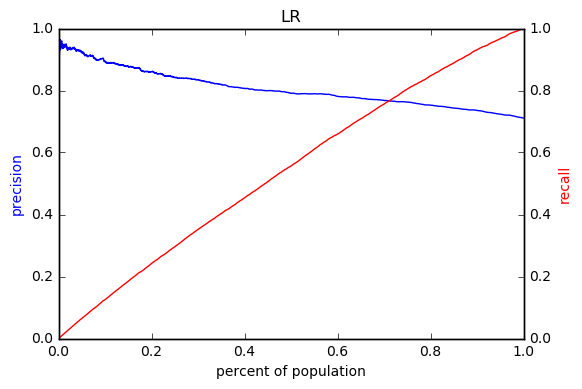

In [14]:
 plot_precision_recall_n(subreddit_id_binary[test_idx], y_score[:,1], 'LR')

## Feature Importances 

Find the five words that are most predictive of each subreddit 

In [15]:
coef = mdl.coef_.ravel()

dict_feature_importances = dict( zip(features, coef) )
orddict_feature_importances = OrderedDict( 
                                sorted(dict_feature_importances.items(), key=lambda x: x[1]) )

ls_sorted_features  = list(orddict_feature_importances.keys())

num_features = 5
subreddit0_features = ls_sorted_features[:5] #SuicideWatch
subreddit1_features = ls_sorted_features[-5:] #depression
print('SuicideWatch: ',subreddit0_features)
print('depression: ', subreddit1_features)

SuicideWatch:  ['suicide', 'please', 'talked', 'suicidal', 'hospital']
depression:  ['helps', 'psychiatrist', 'depressed', 'effects', 'depression']


## See the predictions and how well they match up

In [16]:
#maybe do something with this crazy indexing: this is python not C!
num_comments = 5
subreddit0_comment_idx = y_score[:,1].argsort()[:num_comments] #SuicideWatch
subreddit1_comment_idx = y_score[:,1].argsort()[-num_comments:] #depression

#convert back to the indices of the original dataset
top_comments_testing_set_idx = np.concatenate([subreddit0_comment_idx, 
                                               subreddit1_comment_idx])


In [17]:
#these are the 5 comments the model is most sure of 
for i in top_comments_testing_set_idx:
    print(
        u"""{}:{}\n---\n{}\n===""".format(test_subreddit_id[i],
                                          y_score[i,1],
                                          test_corpus[i]))

SuicideWatch:0.009960331135796377
---
it sounds like you re exhausted on many levels and are losing hope or have lost hope i m so sorry for what it s worth it s striking that you give equal weight in your post to your personal struggles and your existential despair at the state of the world that s pretty remarkable it speaks to your empathy you are not worthless i think that you want to help people you say that you don t even know why you try but it sounds like you do know you care about the world so much that it hurts helping people gives life meaning right and sometimes jerks may deny that or try to take that from you but we all have to fight them i know that i can t imagine the added pain of being trans in a hostile world though some of this i get i m queer too and not in a good situation right now and it sounds like you ve got something eating disordered type stuff going on that certainly makes the world a harder place to live in there is help out there though personally i found su

 The predict probability refer to the probablity of a comment belonging to the depression subreddit. Therefore, comments belonging to the SucideWatch subreddit will have a low probablity. As can be seen from the comments for the three highest probablities for SucideWatch and depression, the classifier does a good job. Note the last entry in the depression comment is miscategorized. This is most likely due to the comment referring to depression and treatment. 

# Topic Modeling: Unsupervised Learning

In this portion of the tutorial we will be extracting topics in the form of commonly co-occuring words from the corpus of data. 

In [18]:
N_TOPICS = 50
N_TOP_WORDS = 10

## Load All the reddit Data

In [19]:
start = time.time()
corpus_all, subreddit_id_all = load_reddit('./data/RC_2015-05.json',MIN_CHAR=250)
end = time.time()
print('Loading takes {0:2f}s'.format(end-start))

Loading takes 4.794395s


## Preprocess the data

In [20]:
# Get rid of punctuation and set to lowercase  
start = time.time()
processed_corpus_all = [ re.sub( RE_PREPROCESS, ' ', comment).lower() for comment in corpus_all]

#tokenzie the words
bag_of_words_all = vectorizer.fit_transform( processed_corpus_all ) 
end = time.time() 
#grab the features/vocabulary
features_all = vectorizer.get_feature_names()
print("Processing took {}s".format(end - start))

Processing took 29.07464623451233s


In [21]:
print(Counter(subreddit_id_all), len(subreddit_id_all))

Counter({'depression': 12079, 'offmychest': 10661, 'stopdrinking': 6958, 'SuicideWatch': 6098, 'ADHD': 5674, 'GetMotivated': 4799, 'Anxiety': 4466, 'Meditation': 3608, 'stopsmoking': 1867, 'leaves': 1629, 'BPD': 1618, 'BipolarReddit': 1515, 'OpiatesRecovery': 1391, 'socialanxiety': 1221, 'StopGaming': 946, 'schizophrenia': 898, 'mentalhealth': 572, 'ptsd': 566, 'MMFB': 483, 'alcoholism': 378, 'rapecounseling': 283, 'BipolarSOs': 272, 'AlAnon': 267, 'ZenHabits': 237, 'alcoholicsanonymous': 219, 'getting_over_it': 208, 'EatingDisorders': 203, 'Anger': 165, 'selfhelp': 150, 'StopSelfHarm': 136, 'dpdr': 105, 'survivorsofabuse': 96, 'helpmecope': 45, 'AtheistTwelveSteppers': 29, 'problemgambling': 17, 'buddhistrecovery': 12, 'MaladaptiveDreaming': 9, 'psychoticreddit': 8, 'PanicAttack': 8, 'secularsobriety': 6, 'SMARTRecovery': 5, 'secondary_survivors': 5, 'hardshipmates': 4, 'PanicParty': 4, 'afterthesilence': 3, 'feelgood': 2, 'jessiesparents': 1, 'Existential_crisis': 1}) 69927


## Create topics

To create our topics we will use the LatentDirichletAllocation algorithm 

In [22]:
start = time.time()
lda = LatentDirichletAllocation( n_topics = N_TOPICS )
doctopic = lda.fit_transform( bag_of_words_all )
end = time.time() 
print("Processing took {}s".format(end- start)) # takes ~72s for 1 file, ~445s for 5 files

/home/akumar/py3venv/lib/python3.4/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Processing took 352.21460127830505s


## Display the top ten words for each topics 

In [36]:

ls_keywords = []
for i,topic in enumerate(lda.components_):
    word_idx = np.argsort(topic)[::-1][:N_TOP_WORDS]
    keywords = ', '.join( features_all[i] for i in word_idx)
    ls_keywords.append(keywords)
    print(i, keywords)
    

0 read, normal, dont, loved, scared, follow, books, skills, found, nearly
1 brain, adhd, issues, use, attention, also, due, cause, part, several
2 job, money, thinking, stop, hours, using, fix, spend, jobs, straight
3 keep, body, mind, practice, simple, reasons, choose, going, helps, kept
4 pretty, school, really, much, high, reading, get, think, lot, end
5 family, us, book, bring, young, wait, interested, called, together, loss
6 http, com, www, http www, reddit, message, reddit com, www reddit, comments, please
7 good, luck, best, good luck, idea, great, recovery, addiction, another, choice
8 less, living, stress, full, knowing, difference, horrible, gave, moved, order
9 gt, amp, org, drugs, words, hang, wiki, research, history, amount
10 else, alone, anyone, others, answer, perhaps, yet, question, something, big
11 thanks, control, thank, told, feels, let, steps, appreciate, inside, feels like
12 feel, better, little, make, left, today, right, lost, god, hope
13 month, eat, take, ex

## first 25 comments with the majority topic

In [37]:
num_comments = 50
for comment_id in range(num_comments):
    topic_id = np.argsort(doctopic[comment_id])[::-1][0]
    print('comment_id:',
          comment_id,
          subreddit_id_all[comment_id],
          'topic_id:',
          topic_id,
          'keywords:',
           ls_keywords[topic_id])
    print('---')
    print(corpus_all[comment_id])
    print('===')

comment_id: 0 offmychest topic_id: 14 keywords: pain, call, life, would, fucking, real, hurt, issue, suicide, gone
---
It's not your fault don't think that. Hey if this helps it does then if it doesn't well. At least I can talk about it.

I shot my dog. I had him for 10 years. I can home from partying and it was New Years so I was going to shoot off my .40 so...

Well I was loading it outside and I shot it off accidentally. Right into my dog. Me having about 5-7 tequila shots into me though if I go to sleep I would wake up and he would be okay. Well if I called a vet when I shot him I could have saved him. Or at least from his pain. So I woke up saw a dead dog in my yard… i cried for hours. That old dog still had a few good years in him. 

That was my fault and you sitting on a little tiny mouse is more understandable than a man discharging a firearm into a shitzu. Don't feel to bad. 
===
comment_id: 1 offmychest topic_id: 4 keywords: pretty, school, really, much, high, reading, get, t

Return to [TOC](#Table-of-Contents)